# Models for Sepsis prediction before 6 hours

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sn

In [29]:
data=pd.read_csv("total.csv")
df=pd.read_csv("test.csv")

In [30]:
data.drop(columns=data.columns[0], axis=1, inplace=True)

In [32]:
X = data.drop(["sepsis_label","Patient_ID"],axis=1)
y = data["sepsis_label"]

**TSNE visualization**

In [10]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(X)
print(standardized_data.shape)

(1452203, 43)


C:\Users\Mangaleswara\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Mangaleswara\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Mangaleswara\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


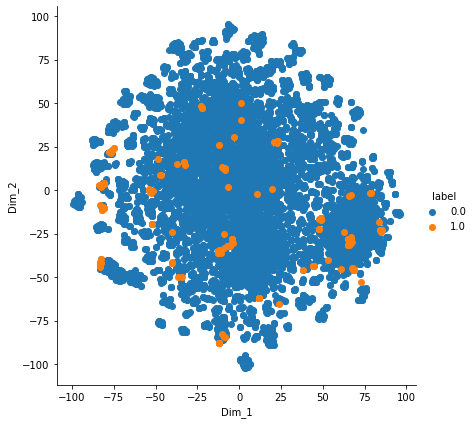

In [16]:
data_1000 = standardized_data[0:10000, :]
labels_1000 = y[0:10000]
model = TSNE(n_components = 2, random_state = 0)
tsne_data = model.fit_transform(data_1000)
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data = tsne_data,
     columns =("Dim_1", "Dim_2", "label"))
sn.FacetGrid(tsne_df, hue ="label", size = 6).map(
       plt.scatter, 'Dim_1', 'Dim_2').add_legend()
 
plt.show()

**MultiDimensional Scaling**

In [18]:
from sklearn.manifold import MDS # for MDS dimensionality reduction
model2d=MDS(n_components=2,
          random_state=42, 
          dissimilarity='euclidean')

X_trans = model2d.fit_transform(data_1000)

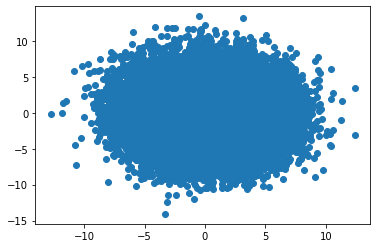

In [22]:
colors=["b","r"]
plt.scatter(X_trans[:,0], X_trans[:,1])
plt.show()

**Sampling**

In [7]:
from imblearn.over_sampling import SMOTE #oversampling. creates new data points of oversampled values
oversample = SMOTE()
X_train_over,y_train_over = oversample.fit_resample(X, y)

In [33]:
from imblearn.under_sampling import NearMiss #undersampling. creates new data points of oversampled values
nr = NearMiss()
X_train_over, y_train_over = nr.fit_resample(X, y.ravel())

In [34]:
X_val = df.drop(["sepsis_label","Patient_ID"],axis=1)
y_val=df["sepsis_label"]

**Standard scaling**

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Instantiate encoder/scaler
scaler = StandardScaler()


# train data
# Scale and Encode Separate Columns
train_scaled_columns  = scaler.fit_transform(X_train_over) 
train_x=scaler.fit_transform(X_train_over)
#train_Y=scaler.fit_transform(y_train_over)
#test_Y=scaler.fit_transform(y_val)
test_x=scaler.fit_transform(X_val)

**Logistic Regression**

In [10]:
model = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False).fit(train_x,y_train_over)

In [11]:
confusion_matrix(y_val, model.predict(test_x))

array([[52144, 45630],
       [  507,  1719]], dtype=int64)

In [12]:
print(classification_report(y_val, model.predict(test_x)))

              precision    recall  f1-score   support

           0       0.99      0.53      0.69     97774
           1       0.04      0.77      0.07      2226

    accuracy                           0.54    100000
   macro avg       0.51      0.65      0.38    100000
weighted avg       0.97      0.54      0.68    100000



Accuracy of 54% with recall of 77% for sepsis patients. Oversampling does better

# Gaussian Naive bayes- the best overall algorithm

In [13]:
#the best
from sklearn.naive_bayes import GaussianNB #oversample does better
gnb = GaussianNB()
gnb.fit(train_x, y_train_over)
y_pred = gnb.predict(test_x)

In [14]:
confusion_matrix(y_val, y_pred)

array([[67848, 29926],
       [  786,  1440]], dtype=int64)

In [15]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.69      0.82     97774
           1       0.05      0.65      0.09      2226

    accuracy                           0.69    100000
   macro avg       0.52      0.67      0.45    100000
weighted avg       0.97      0.69      0.80    100000



Accuracy of 69% with recall of 65% for sepsis patients. Oversampling does better

**K-Means**

In [16]:
from sklearn.cluster import KMeans
model1=KMeans(n_clusters=2, random_state=0).fit(train_x)
kmeans_pred=model1.fit_predict(test_x)

In [17]:
confusion_matrix(y_val, kmeans_pred)

array([[46914, 50860],
       [ 1261,   965]], dtype=int64)

In [18]:
print(classification_report(y_val, kmeans_pred))

              precision    recall  f1-score   support

           0       0.97      0.48      0.64     97774
           1       0.02      0.43      0.04      2226

    accuracy                           0.48    100000
   macro avg       0.50      0.46      0.34    100000
weighted avg       0.95      0.48      0.63    100000



Accuracy of 48% with recall of 43% for sepsis patients. Oversampling does better

# Support Vector Machines in pre-processed data by LDA

Oversampling takes more time for support vector machines to compute, hence we used **undersample technique**. We did **LDA** and use grid search for hyperprameter tuning. We found that **poly kernel with c=1000, gamma=1** to be the best

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA()
model=lda.fit(train_x, y_train_over)
y_pred=model.predict(test_x)
X_train_lda = lda.transform(train_x)
X_test_lda = lda.transform(test_x)

In [9]:
from sklearn.svm import SVC  
clf = SVC(C=1000,gamma=1,kernel='poly') 

In [10]:
model=clf.fit(X_train_lda, y_train_over)

In [11]:
pred=model.predict(X_test_lda)

In [12]:
confusion_matrix(y_val, pred)

array([[82180, 15594],
       [ 1529,   697]], dtype=int64)

In [13]:
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91     97774
           1       0.04      0.31      0.08      2226

    accuracy                           0.83    100000
   macro avg       0.51      0.58      0.49    100000
weighted avg       0.96      0.83      0.89    100000



Accuracy of 83% with recall of 31% for sepsis patients

**Decision tree**

In [14]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
clf_gini = DecisionTreeClassifier(criterion = "gini",
            random_state = 100)

In [16]:
clf_gini.fit(train_x, y_train_over)
y_pred = clf_gini.predict(test_x)

In [17]:
confusion_matrix(y_val, y_pred)

array([[41440, 56334],
       [  689,  1537]], dtype=int64)

In [18]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.42      0.59     97774
           1       0.03      0.69      0.05      2226

    accuracy                           0.43    100000
   macro avg       0.51      0.56      0.32    100000
weighted avg       0.96      0.43      0.58    100000



Accuray of 43% with recall of 69% for sepsis pateients

# Ensemble models

For all undersampling does better

**Random Forest**

In [19]:
from sklearn.ensemble import RandomForestClassifier #undersample does better
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(train_x, y_train_over)
y_pred = clf.predict(test_x)

In [20]:
confusion_matrix(y_val, y_pred)

array([[30409, 67365],
       [  275,  1951]], dtype=int64)

In [21]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.31      0.47     97774
           1       0.03      0.88      0.05      2226

    accuracy                           0.32    100000
   macro avg       0.51      0.59      0.26    100000
weighted avg       0.97      0.32      0.46    100000



Accuray of 32% with recall of 88% for sepsis pateients

**LightGBM**

In [26]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [27]:
model = LGBMClassifier() #undersample does better
model.fit(train_x, y_train_over)
pred = model.predict(test_x)
accuracy = model.score(test_x, y_val)

In [28]:
confusion_matrix(y_val, pred)

array([[33719, 64055],
       [  338,  1888]], dtype=int64)

In [29]:
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.99      0.34      0.51     97774
           1       0.03      0.85      0.06      2226

    accuracy                           0.36    100000
   macro avg       0.51      0.60      0.28    100000
weighted avg       0.97      0.36      0.50    100000



Accuray of 36% with recall of 85% for sepsis pateients

**Extra Trees Classifier**

In [30]:
from sklearn.ensemble import ExtraTreesClassifier #undersample does better
extra_tree_forest = ExtraTreesClassifier(
                                        criterion ='entropy')
extra_tree_forest.fit(train_x, y_train_over)
pred = extra_tree_forest.predict(test_x)
accuracy = extra_tree_forest.score(test_x, y_val)

In [31]:
confusion_matrix(y_val, pred)

array([[37652, 60122],
       [  339,  1887]], dtype=int64)

In [32]:
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.99      0.39      0.55     97774
           1       0.03      0.85      0.06      2226

    accuracy                           0.40    100000
   macro avg       0.51      0.62      0.31    100000
weighted avg       0.97      0.40      0.54    100000



Accuray of 40% with recall of 85% for sepsis pateients

**XGBoost**

In [36]:
import xgboost as xgb
xg_reg = xgb.XGBClassifier()

In [38]:
xg_reg.fit(train_x, y_train_over)
pred = xg_reg.predict(test_x)

In [39]:
confusion_matrix(y_val, pred)

array([[39612, 58162],
       [  448,  1778]], dtype=int64)

In [40]:
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.99      0.41      0.57     97774
           1       0.03      0.80      0.06      2226

    accuracy                           0.41    100000
   macro avg       0.51      0.60      0.32    100000
weighted avg       0.97      0.41      0.56    100000



Accuray of 41% with recall of 80% for sepsis pateients

**Dropping columns and running model with less features**

In [4]:
data.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'BaseExcess',
       'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'BUN', 'Calcium', 'Chloride',
       'Creatinine', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate',
       'Potassium', 'Bilirubin_total', 'Hct', 'Hgb', 'PTT', 'WBC', 'Platelets',
       'Hour', 'Age', 'Gender', 'Patient_ID', 'ICULOS', 'sepsis_label',
       'HR_diff', 'SPO2_diff', 'Temp_diff', 'SBP_diff', 'MAP_diff', 'DBP_diff',
       'Resp_diff', 'GI', 'shock_index', 'partial_sofa', 'quick_sofa'],
      dtype='object')

In [17]:
X = data.drop(["sepsis_label","Patient_ID","HR","O2Sat","Temp","SBP","MAP","DBP","Resp","BaseExcess","PaCO2","Calcium","Chloride",
               "Lactate","Glucose","Phosphate","Hct","Hgb","PTT","Age","Platelets","Temp_diff","HR_diff","HCO3","SaO2","pH"
              ,"SBP_diff","MAP_diff","DBP_diff","SPO2_diff","Creatinine","Bilirubin_total"],axis=1)
y = data["sepsis_label"]

In [18]:
from imblearn.over_sampling import SMOTE #oversampling. creates new data points of oversampled values
oversample = SMOTE()
X_train_over,y_train_over = oversample.fit_resample(X, y)

In [6]:
from imblearn.under_sampling import NearMiss #undersampling. creates new data points of oversampled values
nr = NearMiss()
X_train_over, y_train_over = nr.fit_resample(X, y.ravel())

In [19]:
X_val = df.drop(["sepsis_label","Patient_ID","HR","O2Sat","Temp","SBP","MAP","DBP","Resp","BaseExcess","PaCO2","Calcium","Chloride",
               "Lactate","Glucose","Phosphate","Hct","Hgb","PTT","Age","Platelets","Temp_diff","HR_diff","HCO3","SaO2","pH"
              ,"SBP_diff","MAP_diff","DBP_diff","SPO2_diff","Creatinine","Bilirubin_total"],axis=1)
y_val=df["sepsis_label"]

In [20]:
X_val.columns

Index(['FiO2', 'BUN', 'Magnesium', 'Potassium', 'WBC', 'Hour', 'Gender',
       'ICULOS', 'Resp_diff', 'GI', 'shock_index', 'partial_sofa',
       'quick_sofa'],
      dtype='object')

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Instantiate encoder/scaler
scaler = StandardScaler()


# train data
# Scale and Encode Separate Columns
train_scaled_columns  = scaler.fit_transform(X_train_over) 
train_x=scaler.fit_transform(X_train_over)
#train_Y=scaler.fit_transform(y_train_over)
#test_Y=scaler.fit_transform(y_val)
test_x=scaler.fit_transform(X_val)

# Gaussian Naive bayes- the best overall algorithm

In [95]:
from sklearn.naive_bayes import GaussianNB #oversample does better
gnb = GaussianNB()
gnb.fit(train_x, y_train_over)
y_pred = gnb.predict(test_x)

In [96]:
confusion_matrix(y_val, y_pred)

array([[75628, 22146],
       [  985,  1241]], dtype=int64)

In [97]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.77      0.87     97774
           1       0.05      0.56      0.10      2226

    accuracy                           0.77    100000
   macro avg       0.52      0.67      0.48    100000
weighted avg       0.97      0.77      0.85    100000



**Accuray of 77% with recall of 56% for sepsis pateients**

**Logistic Regression**

In [22]:
model = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False).fit(train_x,y_train_over)

In [23]:
confusion_matrix(y_val, model.predict(test_x))

array([[53485, 44289],
       [  656,  1570]], dtype=int64)

In [24]:
print(classification_report(y_val, model.predict(test_x)))

              precision    recall  f1-score   support

           0       0.99      0.55      0.70     97774
           1       0.03      0.71      0.07      2226

    accuracy                           0.55    100000
   macro avg       0.51      0.63      0.38    100000
weighted avg       0.97      0.55      0.69    100000



Accuray of 55% with recall of 71% for sepsis pateients

# Support Vector Machines in pre-processed data by LDA

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA()
model=lda.fit(train_x, y_train_over)
y_pred=model.predict(test_x)
X_train_lda = lda.transform(train_x)
X_test_lda = lda.transform(test_x)

In [11]:
from sklearn.svm import SVC  
clf = SVC(C=1000,gamma=1,kernel='poly') 

In [12]:
model=clf.fit(X_train_lda, y_train_over)

In [14]:
pred=model.predict(X_test_lda)

In [15]:
confusion_matrix(y_val, pred)

array([[86646, 11128],
       [ 1398,   828]], dtype=int64)

In [16]:
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93     97774
           1       0.07      0.37      0.12      2226

    accuracy                           0.87    100000
   macro avg       0.53      0.63      0.52    100000
weighted avg       0.96      0.87      0.91    100000

